# Regression Predict Student Solution

© Explore Data Science Academy

---
### Honour Code

I, **Team GM5**, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.

### Predict Overview: Spain Electricity Shortfall Challenge

The government of Spain is considering an expansion of it's renewable energy resource infrastructure investments. As such, they require information on the trends and patterns of the countries renewable sources and fossil fuel energy generation. Your company has been awarded the contract to:

- 1. analyse the supplied data;
- 2. identify potential errors in the data and clean the existing data set;
- 3. determine if additional features can be added to enrich the data set;
- 4. build a model that is capable of forecasting the three hourly demand shortfalls;
- 5. evaluate the accuracy of the best machine learning model;
- 6. determine what features were most important in the model’s prediction decision, and
- 7. explain the inner working of the model to a non-technical audience.

Formally the problem statement was given to you, the senior data scientist, by your manager via email reads as follow:

> In this project you are tasked to model the shortfall between the energy generated by means of fossil fuels and various renewable sources - for the country of Spain. The daily shortfall, which will be referred to as the target variable, will be modelled as a function of various city-specific weather features such as `pressure`, `wind speed`, `humidity`, etc. As with all data science projects, the provided features are rarely adequate predictors of the target variable. As such, you are required to perform feature engineering to ensure that you will be able to accurately model Spain's three hourly shortfalls.
 
On top of this, she has provided you with a starter notebook containing vague explanations of what the main outcomes are. 

 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>



In [3738]:
# Libraries for data loading, data manipulation and data visulisation
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.graphics.correlation import plot_corr
import plotly.express as px
pd.set_option('max_columns', 200)

# Libraries for data preparation and model building
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics 
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2 
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import math
from statsmodels.graphics.correlation import plot_corr
import statsmodels.formula.api as sm
from statsmodels.formula.api import ols
from scipy.stats import pearsonr
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RandomizedSearchCV

# Time series imports
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import timedelta
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [3739]:
# load data
train_data = pd.read_csv('df_train.csv')
test_data = pd.read_csv('df_test.csv') 

<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


---

Initial observations:

1. The feature, more specifically, "Valencia Pressure" is missing various observations.  

2. There is a feature called "Unnamed: 0", which does not add any substantive information to the overall dataset.   

3. As we will be more fully shown below, the datatype of the features, more specifically, "time", "Valencia_wind_deg" and "Seville_pressure", are incorrectly classed as an object.    

4. There quite a few features that are largely empty, and does not contain any valuable informatation that contributes to the overall dataset, such as the "Seville_clouds_all" and "Bilbao_snow_3h" columns.

5. As will be more fully shown below, there are quite a few outliers present, which evidently disturbs the natural orientation of our dataset. 

6. Multicollinearity appears to be extremely prevalent between the various features.  

---

In [3740]:
print(f' There are {train_data.shape[0]} rows and {train_data.shape[1]} columns in the data set.')

 There are 8763 rows and 49 columns in the data set.


In [3741]:
# Train data preview
train_data.head()

,Unnamed: 0,time,Madrid_wind_speed,Valencia_wind_deg,Bilbao_rain_1h,Valencia_wind_speed,Seville_humidity,Madrid_humidity,Bilbao_clouds_all,Bilbao_wind_speed,Seville_clouds_all,Bilbao_wind_deg,Barcelona_wind_speed,Barcelona_wind_deg,Madrid_clouds_all,Seville_wind_speed,Barcelona_rain_1h,Seville_pressure,Seville_rain_1h,Bilbao_snow_3h,Barcelona_pressure,Seville_rain_3h,Madrid_rain_1h,Barcelona_rain_3h,Valencia_snow_3h,Madrid_weather_id,Barcelona_weather_id,Bilbao_pressure,Seville_weather_id,Valencia_pressure,Seville_temp_max,Madrid_pressure,Valencia_temp_max,Valencia_temp,Bilbao_weather_id,Seville_temp,Valencia_humidity,Valencia_temp_min,Barcelona_temp_max,Madrid_temp_max,Barcelona_temp,Bilbao_temp_min,Bilbao_temp,Barcelona_temp_min,Bilbao_temp_max,Seville_temp_min,Madrid_temp,Madrid_temp_min,load_shortfall_3h
0,0,2015-01-01 03:00:00,0.666667,level_5,0.0,0.666667,74.333333,64.000000,0.0,1.000000,0.0,223.333333,6.333333,42.666667,0.0,3.333333,0.0,sp25,0.0,0.0,1036.333333,0.0,0.0,0.0,0.0,800.0,800.0,1035.000000,800.0,1002.666667,274.254667,971.333333,269.888000,269.888000,800.0,274.254667,75.666667,269.888000,281.013000,265.938000,281.013000,269.338615,269.338615,281.013000,269.338615,274.254667,265.938000,265.938000,6715.666667
1,1,2015-01-01 06:00:00,0.333333,level_10,0.0,1.666667,78.333333,64.666667,0.0,1.000000,0.0,221.000000,4.000000,139.000000,0.0,3.333333,0.0,sp25,0.0,0.0,1037.333333,0.0,0.0,0.0,0.0,800.0,800.0,1035.666667,800.0,1004.333333,274.945000,972.666667,271.728333,271.728333,800.0,274.945000,71.000000,271.728333,280.561667,266.386667,280.561667,270.376000,270.376000,280.561667,270.376000,274.945000,266.386667,266.386667,4171.666667
2,2,2015-01-01 09:00:00,1.000000,level_9,0.0,1.000000,71.333333,64.333333,0.0,1.000000,0.0,214.333333,2.000000,326.000000,0.0,2.666667,0.0,sp25,0.0,0.0,1038.000000,0.0,0.0,0.0,0.0,800.0,800.0,1036.000000,800.0,1005.333333,278.792000,974.000000,278.008667,278.008667,800.0,278.792000,65.666667,278.008667,281.583667,272.708667,281.583667,275.027229,275.027229,281.583667,275.027229,278.792000,272.708667,272.708667,4274.666667
3,3,2015-01-01 12:00:00,1.000000,level_8,0.0,1.000000,65.333333,56.333333,0.0,1.000000,0.0,199.666667,2.333333,273.000000,0.0,4.000000,0.0,sp25,0.0,0.0,1037.000000,0.0,0.0,0.0,0.0,800.0,800.0,1036.000000,800.0,1009.000000,285.394000,994.666667,284.899552,284.899552,800.0,285.394000,54.000000,284.899552,283.434104,281.895219,283.434104,281.135063,281.135063,283.434104,281.135063,285.394000,281.895219,281.895219,5075.666667
4,4,2015-01-01 15:00:00,1.000000,level_7,0.0,1.000000,59.000000,57.000000,2.0,0.333333,0.0,185.000000,4.333333,260.000000,0.0,3.000000,0.0,sp25,0.0,0.0,1035.000000,0.0,0.0,0.0,0.0,800.0,800.0,1035.333333,800.0,NaN,285.513719,1035.333333,283.015115,283.015115,800.0,285.513719,58.333333,283.015115,284.213167,280.678437,284.213167,282.252063,282.252063,284.213167,282.252063,285.513719,280.678437,280.678437,6620.666667


- Next, we will take a look at the datatypes of our dataset, as well as the quantification of NULL values in our dataset.   

In [3742]:
# View of our train info
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 49 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            8763 non-null   int64  
 1   time                  8763 non-null   object 
 2   Madrid_wind_speed     8763 non-null   float64
 3   Valencia_wind_deg     8763 non-null   object 
 4   Bilbao_rain_1h        8763 non-null   float64
 5   Valencia_wind_speed   8763 non-null   float64
 6   Seville_humidity      8763 non-null   float64
 7   Madrid_humidity       8763 non-null   float64
 8   Bilbao_clouds_all     8763 non-null   float64
 9   Bilbao_wind_speed     8763 non-null   float64
 10  Seville_clouds_all    8763 non-null   float64
 11  Bilbao_wind_deg       8763 non-null   float64
 12  Barcelona_wind_speed  8763 non-null   float64
 13  Barcelona_wind_deg    8763 non-null   float64
 14  Madrid_clouds_all     8763 non-null   float64
 15  Seville_wind_speed   

In [3743]:
# View of the null values in our dataset
train_data.isnull().sum()

Unnamed: 0                 0
time                       0
Madrid_wind_speed          0
Valencia_wind_deg          0
Bilbao_rain_1h             0
Valencia_wind_speed        0
Seville_humidity           0
Madrid_humidity            0
Bilbao_clouds_all          0
Bilbao_wind_speed          0
Seville_clouds_all         0
Bilbao_wind_deg            0
Barcelona_wind_speed       0
Barcelona_wind_deg         0
Madrid_clouds_all          0
Seville_wind_speed         0
Barcelona_rain_1h          0
Seville_pressure           0
Seville_rain_1h            0
Bilbao_snow_3h             0
Barcelona_pressure         0
Seville_rain_3h            0
Madrid_rain_1h             0
Barcelona_rain_3h          0
Valencia_snow_3h           0
Madrid_weather_id          0
Barcelona_weather_id       0
Bilbao_pressure            0
Seville_weather_id         0
Valencia_pressure       2068
Seville_temp_max           0
Madrid_pressure            0
Valencia_temp_max          0
Valencia_temp              0
Bilbao_weather

- Using the describe function, we will calculate the statistical data of the dataframe, including but not limited to, the mean, standard deviation and percentile. 

In [3744]:
# Statistical analysis
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,8763.0,4381.000000,2529.804538,0.000000,2190.500000,4381.000000,6571.500000,8.762000e+03
Madrid_wind_speed,8763.0,2.425729,1.850371,0.000000,1.000000,2.000000,3.333333,1.300000e+01
Bilbao_rain_1h,8763.0,0.135753,0.374901,0.000000,0.000000,0.000000,0.100000,3.000000e+00
Valencia_wind_speed,8763.0,2.586272,2.411190,0.000000,1.000000,1.666667,3.666667,5.200000e+01
Seville_humidity,8763.0,62.658793,22.621226,8.333333,44.333333,65.666667,82.000000,1.000000e+02
Madrid_humidity,8763.0,57.414717,24.335396,6.333333,36.333333,58.000000,78.666667,1.000000e+02
Bilbao_clouds_all,8763.0,43.469132,32.551044,0.000000,10.000000,45.000000,75.000000,1.000000e+02
Bilbao_wind_speed,8763.0,1.850356,1.695888,0.000000,0.666667,1.000000,2.666667,1.266667e+01
Seville_clouds_all,8763.0,13.714748,24.272482,0.000000,0.000000,0.000000,20.000000,9.733333e+01
Bilbao_wind_deg,8763.0,158.957511,102.056299,0.000000,73.333333,147.000000,234.000000,3.593333e+02


- Next, we shall analyse the correlation between the various numerical variables, so that we may be in a better position to decide on what features that we should either keep or remove from our model. 

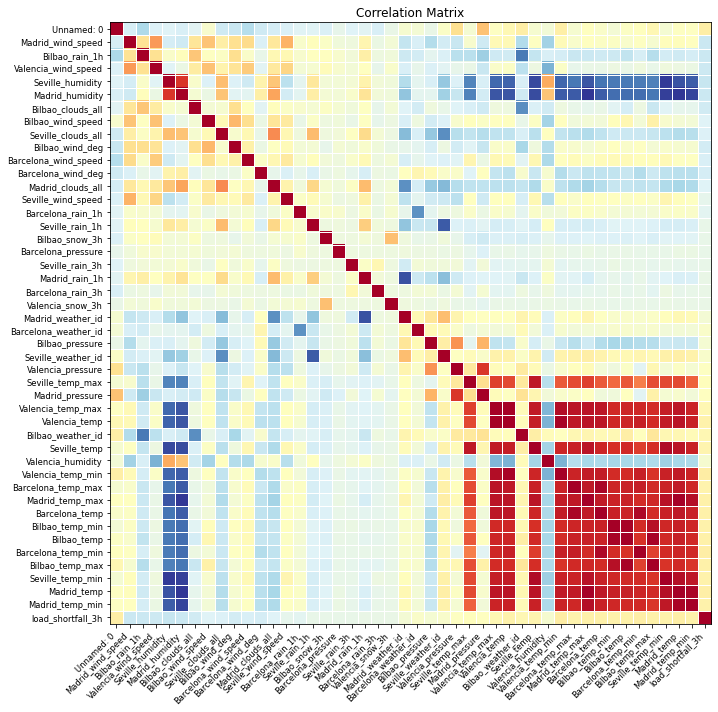

In [3745]:
# Heatmap of correlation
fig = plt.figure(figsize=(10,10));
ax = fig.add_subplot(111);
plot_corr(train_data.corr(), xnames = train_data.corr().columns, ax = ax);

In [3746]:
# Numerical correlation 
train_data.corr()

,Unnamed: 0,Madrid_wind_speed,Bilbao_rain_1h,Valencia_wind_speed,Seville_humidity,Madrid_humidity,Bilbao_clouds_all,Bilbao_wind_speed,Seville_clouds_all,Bilbao_wind_deg,Barcelona_wind_speed,Barcelona_wind_deg,Madrid_clouds_all,Seville_wind_speed,Barcelona_rain_1h,Seville_rain_1h,Bilbao_snow_3h,Barcelona_pressure,Seville_rain_3h,Madrid_rain_1h,Barcelona_rain_3h,Valencia_snow_3h,Madrid_weather_id,Barcelona_weather_id,Bilbao_pressure,Seville_weather_id,Valencia_pressure,Seville_temp_max,Madrid_pressure,Valencia_temp_max,Valencia_temp,Bilbao_weather_id,Seville_temp,Valencia_humidity,Valencia_temp_min,Barcelona_temp_max,Madrid_temp_max,Barcelona_temp,Bilbao_temp_min,Bilbao_temp,Barcelona_temp_min,Bilbao_temp_max,Seville_temp_min,Madrid_temp,Madrid_temp_min,load_shortfall_3h
Unnamed: 0,1.000000,-0.109288,-0.249633,-0.090161,-0.079025,-0.103359,-0.068123,0.049197,-0.140583,-0.155738,-0.218781,-0.140449,-0.116928,-0.093926,-0.075692,-0.075340,-0.092377,-0.040157,-0.082525,-0.068980,-0.104326,-0.028130,0.047202,0.034761,-0.022475,0.072472,0.267772,0.039424,0.385578,0.087002,0.135294,0.192485,0.042897,0.023917,0.185468,0.047417,0.093378,0.068078,0.028698,0.081799,0.103436,0.146216,0.037487,0.088439,0.085197,0.192612
Madrid_wind_speed,-0.109288,1.000000,0.259719,0.513092,-0.117892,-0.137092,0.244001,0.377854,0.191251,0.270950,0.294640,-0.095380,0.230126,0.434104,0.062758,0.108413,0.071183,0.011134,0.004795,0.150446,-0.014644,0.021660,-0.169358,-0.099582,-0.231747,-0.120014,-0.157088,0.050043,-0.136672,0.133468,0.128726,-0.238128,0.090861,-0.285787,0.119657,0.061854,0.091464,0.080133,0.077330,0.060467,0.089992,0.042114,0.110278,0.109572,0.098138,-0.150981
Bilbao_rain_1h,-0.249633,0.259719,1.000000,0.265864,0.069878,0.106765,0.370733,0.085398,0.081131,0.279350,0.069997,-0.030723,0.135524,0.140101,0.052558,0.092984,0.096730,0.052458,0.016392,0.187423,-0.001412,0.008269,-0.147768,-0.120618,-0.054814,-0.095723,-0.206765,-0.210323,-0.298587,-0.135198,-0.127953,-0.604616,-0.170009,-0.103868,-0.116835,-0.157326,-0.148397,-0.138901,-0.141269,-0.182494,-0.106593,-0.219871,-0.120575,-0.135927,-0.116431,-0.152510
Valencia_wind_speed,-0.090161,0.513092,0.265864,1.000000,-0.075227,-0.019388,0.210524,0.386478,0.163675,0.248643,0.347966,-0.066071,0.221887,0.316035,0.031804,0.046085,0.115133,0.050282,0.027637,0.093865,-0.037553,0.058629,-0.099056,-0.037605,-0.096374,-0.069092,-0.041408,-0.024045,-0.158475,0.065815,0.072366,-0.201379,-0.008508,-0.413017,0.075533,-0.040998,-0.021970,-0.021456,-0.010166,-0.022676,0.001413,-0.033271,0.003618,-0.011982,-0.019742,-0.142791
Seville_humidity,-0.079025,-0.117892,0.069878,-0.075227,1.000000,0.799831,0.061680,-0.088180,0.399436,-0.087246,-0.138625,0.164064,0.366602,-0.202449,-0.051022,0.227476,0.023556,0.021599,0.034343,0.164019,0.015555,0.007351,-0.228442,-0.050515,-0.099458,-0.328265,-0.088094,-0.566426,-0.103813,-0.650643,-0.663276,-0.105088,-0.743126,0.464012,-0.657427,-0.606770,-0.708937,-0.617797,-0.605493,-0.604733,-0.595065,-0.583718,-0.784850,-0.717171,-0.688664,-0.167290
Madrid_humidity,-0.103359,-0.137092,0.106765,-0.019388,0.799831,1.000000,0.041878,-0.016808,0.374112,-0.069570,-0.058518,0.183725,0.484293,-0.125680,-0.061265,0.195455,0.031653,0.025198,0.059958,0.250614,0.017797,0.012571,-0.341407,-0.051139,-0.053074,-0.291095,-0.168207,-0.576413,-0.121737,-0.705918,-0.706989,-0.139686,-0.738819,0.378980,-0.689854,-0.691803,-0.803260,-0.684867,-0.635760,-0.634825,-0.636777,-0.611395,-0.769591,-0.802605,-0.759633,-0.150536
Bilbao_clouds_all,-0.068123,0.244001,0.370733,0.210524,0.061680,0.041878,1.000000,0.031915,0.046737,0.280154,0.094019,-0.065120,0.109788,0.075066,0.052913,0.041090,0.080180,0.037506,0.009557,0.089281,-0.041013,0.024339,-0.080837,-0.124169,0.000377,-0.033825,-0.079778,-0.102322,-0.135672,0.002621,-0.000299,-0.536205,-0.095003,-0.129684,-0.003806,-0.034040,-0.048491,-0.023171,-0.067731,-0.114118,-0.010804,-0.158014,-0.077417,-0.046686,-0.046189,-0.127293
Bilbao_wind_speed,0.049197,0.37785

- As highlighted above, there is exists a particularly high correlation between the variables at the bottom right of the correlation matrix, more specifically, the temperatures and pressures of the numerous cities.  

- In the following section, we shall look into the skew and kurtosis of our dataset. 

- Kurtosis is regarded as the sharpness of the peak of a frequency-distribution curve. 

- A data set with a high kurtosis tends to have heavy tails, and/or outliers, while a low kurtosis tends to have light tails, and/or a lack outliers. As a result of the aforementioned, a high kurtosis is indicated by a numerical value greater than 3, while a low kurtosis is indicated by a numerical value less than 3. 


In [3747]:
# Kurtosis distribution 
train_data.kurtosis()

/var/folders/fk/6yp31bpx0xg5d5cfzf_k_21m0000gn/T/ipykernel_1998/2448157351.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



Unnamed: 0                -1.200000
Madrid_wind_speed          2.036462
Bilbao_rain_1h            32.904656
Valencia_wind_speed       35.645426
Seville_humidity          -1.017983
Madrid_humidity           -1.167537
Bilbao_clouds_all         -1.533417
Bilbao_wind_speed          3.631565
Seville_clouds_all         2.155921
Bilbao_wind_deg           -1.083530
Barcelona_wind_speed       1.493635
Barcelona_wind_deg        -0.959160
Madrid_clouds_all          0.142079
Seville_wind_speed         1.398580
Barcelona_rain_1h        101.578931
Seville_rain_1h           93.840746
Bilbao_snow_3h           806.128471
Barcelona_pressure      3687.564230
Seville_rain_3h          413.136592
Madrid_rain_1h            76.584491
Barcelona_rain_3h        187.800460
Valencia_snow_3h        4089.323165
Madrid_weather_id          9.259047
Barcelona_weather_id       5.701882
Bilbao_pressure            1.825323
Seville_weather_id        10.710308
Valencia_pressure          2.211823
Seville_temp_max          -0

- As can be gleaned from the above, it appears that feautures, such as, "Seville_rain_3h", "Madrid_rain_1h", "Barcelona_rain_3h", "Valencia_snow_3h", "Bilbao_rain_1h", "Valencia_wind_speed" and "Bilbao_wind_speed" have a high degree of kurtosis and/or outliers. 

- The following columns can be regarded as being fairly symetrical in nature, more specifically, "Bilbao_temp", "Bilbao_temp_max", "Seville_temp_min", "Madrid_temp", "Madrid_temp_min" and "load_shortfall_3h". 

/var/folders/fk/6yp31bpx0xg5d5cfzf_k_21m0000gn/T/ipykernel_1998/1599117848.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



<AxesSubplot:>

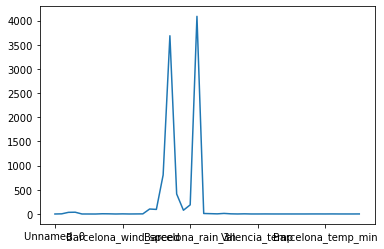

In [3748]:
# Kurtosis plot
train_data.kurtosis().plot()

- Skewness is regarded as the degree of asymmetry obeserved in a distribution. 

- As can be gleaned from the below, there are numerous positive and negative symmetrical relationships between the various features.    

/var/folders/fk/6yp31bpx0xg5d5cfzf_k_21m0000gn/T/ipykernel_1998/2581242043.py:3: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



<AxesSubplot:>

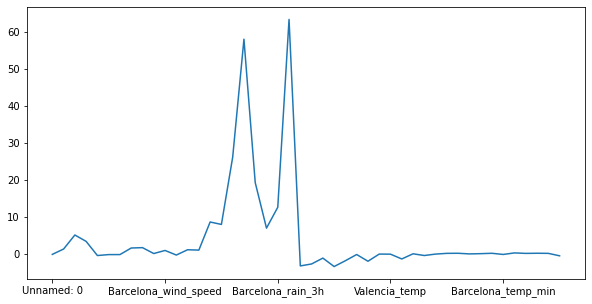

In [3749]:
# Skew plot
plt.figure(figsize = [10,5])
train_data.skew(axis=0, skipna=True).plot()

In [3750]:
# Skew distribution
train_data.skew()

/var/folders/fk/6yp31bpx0xg5d5cfzf_k_21m0000gn/T/ipykernel_1998/1745874054.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



Unnamed: 0               0.000000
Madrid_wind_speed        1.441144
Bilbao_rain_1h           5.222802
Valencia_wind_speed      3.499637
Seville_humidity        -0.310175
Madrid_humidity         -0.057378
Bilbao_clouds_all       -0.053085
Bilbao_wind_speed        1.716914
Seville_clouds_all       1.814452
Bilbao_wind_deg          0.226927
Barcelona_wind_speed     1.057331
Barcelona_wind_deg      -0.180001
Madrid_clouds_all        1.246745
Seville_wind_speed       1.151006
Barcelona_rain_1h        8.726988
Seville_rain_1h          8.067341
Bilbao_snow_3h          26.177568
Barcelona_pressure      57.979664
Seville_rain_3h         19.342574
Madrid_rain_1h           7.074308
Barcelona_rain_3h       12.696605
Valencia_snow_3h        63.298084
Madrid_weather_id       -3.107722
Barcelona_weather_id    -2.584011
Bilbao_pressure         -0.999642
Seville_weather_id      -3.275574
Valencia_pressure       -1.705162
Seville_temp_max        -0.033931
Madrid_pressure         -1.850768
Valencia_temp_

- Lastly, as part of our exploratory data analysis, we shall investigate the impact of time on our target variable, more specifically, the load shortfall partitioned in three-hour windows.

- As gleaned from the below, there is an indication that the load shortfall reduced up until 2016, and same steadily increased from thereon.  

In [3751]:
# Visualising yearly shortfall
px.line(train_data.groupby([train_data['time'].astype('datetime64').dt.year])['load_shortfall_3h'].mean(),
        title = 'Load Shortfall 3h Grouped by Year',
        y='load_shortfall_3h',width =800, height=500 )

In [3752]:
# Visualising monthly shortfall
px.line(train_data.groupby([train_data['time'].astype('datetime64').dt.month])['load_shortfall_3h'].mean(),
        title = 'Load Shortfall 3h Grouped by Month',
        y='load_shortfall_3h', width =800, height=500)

In [3753]:
# Visualising weekly shortfall
px.line(train_data.groupby([train_data['time'].astype('datetime64').dt.weekofyear])['load_shortfall_3h'].mean(), 
        title = 'Load Shortfall 3h Grouped by Week', y='load_shortfall_3h', width =800, height=500)

/var/folders/fk/6yp31bpx0xg5d5cfzf_k_21m0000gn/T/ipykernel_1998/982080527.py:2: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [3754]:
# Visualising daily shortfall
px.line(train_data.groupby([train_data['time'].astype('datetime64').dt.dayofyear])['load_shortfall_3h'].mean(), 
        title = 'Load Shortfall 3h Grouped by Day', y='load_shortfall_3h', width =800, height=500)

In [3755]:
# Visualising weekday shortfall
px.line(train_data.groupby([train_data['time'].astype('datetime64').dt.dayofweek])['load_shortfall_3h'].mean(), 
        title = 'Load Shortfall 3h Grouped by Day of the Week', y='load_shortfall_3h', width =800, height=500 )

In [3756]:
# Visualising hourly shortfall
px.line(train_data.groupby([train_data['time'].astype('datetime64').dt.hour])['load_shortfall_3h'].mean(), 
        title = 'Load Shortfall 3h Grouped by Hour', y='load_shortfall_3h', width =800, height=500 )

- It appears that the Load Shortfall variable follows a relatively normal distribution, and does not appear to contain any abnormalities. 

(array([7.000e+01, 3.720e+02, 8.370e+02, 1.641e+03, 2.494e+03, 2.301e+03,
        9.000e+02, 1.400e+02, 7.000e+00, 1.000e+00]),
 array([-6618. , -2765.8,  1086.4,  4938.6,  8790.8, 12643. , 16495.2,
        20347.4, 24199.6, 28051.8, 31904. ]),
 <BarContainer object of 10 artists>)

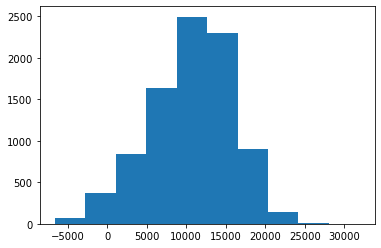

In [3757]:
# Visualing histogram of target variable
plt.hist(train_data['load_shortfall_3h'])

<a id="four"></a>
## 4. Data Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---

As an essential stage to the data science process, it is imperative that we thoroughly clean our data. Once our data has been cleaned, it allows us to attain accurate and reliable insights into our data. 

Together with data cleaning, the process of data engineering consists of the following:

1. Feature analysis and selection; 

2. Creation of new features;

3. Fixing and/or removing duplicate, or incomplete data within a dataset; and

4. Converting data from one format or structure into another. 

Initial observations:

1. As observed above, we need to remove some columns, including but not limited to, the "Unnamed: 0" column from our data set. 

2. The "time" column will need to be converted into the appropriate DateTime format. 

3. Some columns will need to be converted into the correct integer format.

---

In [3758]:
# Creating a copy of our dataset
train_data = train_data.copy()

In [3759]:
# Impute missing values using the mode of the 'Valencia_pressure" column
df_train['Valencia_pressure'].fillna(df_train['Valencia_pressure'].mean(), inplace = True)
df_train['Valencia_pressure'].isnull().sum()

0

In [3760]:
# Converting the "Valencia_wind_deg" and "Seville_pressure" columns into the correct data type. 
train_data['Valencia_wind_deg'] = train_data['Valencia_wind_deg'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)
train_data['Seville_pressure'] = train_data['Seville_pressure'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)

In [3761]:
train_data['Barcelona_pressure'].where(train_data['Barcelona_pressure'] <= 1084, 0, inplace=True)

In [3762]:
# Converting the "time" column to a DateTime format
train_data['time'] = pd.to_datetime(train_data['time'])
train_data['year'] = train_data['time'].dt.year
train_data['month'] = train_data['time'].dt.month
train_data['day'] = train_data['time'].dt.day
train_data['hour'] = train_data['time'].dt.hour
train_data['week_day'] = train_data['time'].dt.dayofweek

In [3763]:
# Drop the "unnamed:0" and "time" columnns from data set
train_data = train_data.drop(['Unnamed: 0', 'time'], axis =1)
train_data.head()


,Madrid_wind_speed,Valencia_wind_deg,Bilbao_rain_1h,Valencia_wind_speed,Seville_humidity,Madrid_humidity,Bilbao_clouds_all,Bilbao_wind_speed,Seville_clouds_all,Bilbao_wind_deg,Barcelona_wind_speed,Barcelona_wind_deg,Madrid_clouds_all,Seville_wind_speed,Barcelona_rain_1h,Seville_pressure,Seville_rain_1h,Bilbao_snow_3h,Barcelona_pressure,Seville_rain_3h,Madrid_rain_1h,Barcelona_rain_3h,Valencia_snow_3h,Madrid_weather_id,Barcelona_weather_id,Bilbao_pressure,Seville_weather_id,Valencia_pressure,Seville_temp_max,Madrid_pressure,Valencia_temp_max,Valencia_temp,Bilbao_weather_id,Seville_temp,Valencia_humidity,Valencia_temp_min,Barcelona_temp_max,Madrid_temp_max,Barcelona_temp,Bilbao_temp_min,Bilbao_temp,Barcelona_temp_min,Bilbao_temp_max,Seville_temp_min,Madrid_temp,Madrid_temp_min,load_shortfall_3h,year,month,day,hour,week_day
0,0.666667,5,0.0,0.666667,74.333333,64.000000,0.0,1.000000,0.0,223.333333,6.333333,42.666667,0.0,3.333333,0.0,25,0.0,0.0,1036.333333,0.0,0.0,0.0,0.0,800.0,800.0,1035.000000,800.0,1002.666667,274.254667,971.333333,269.888000,269.888000,800.0,274.254667,75.666667,269.888000,281.013000,265.938000,281.013000,269.338615,269.338615,281.013000,269.338615,274.254667,265.938000,265.938000,6715.666667,2015,1,1,3,3
1,0.333333,10,0.0,1.666667,78.333333,64.666667,0.0,1.000000,0.0,221.000000,4.000000,139.000000,0.0,3.333333,0.0,25,0.0,0.0,1037.333333,0.0,0.0,0.0,0.0,800.0,800.0,1035.666667,800.0,1004.333333,274.945000,972.666667,271.728333,271.728333,800.0,274.945000,71.000000,271.728333,280.561667,266.386667,280.561667,270.376000,270.376000,280.561667,270.376000,274.945000,266.386667,266.386667,4171.666667,2015,1,1,6,3
2,1.000000,9,0.0,1.000000,71.333333,64.333333,0.0,1.000000,0.0,214.333333,2.000000,326.000000,0.0,2.666667,0.0,25,0.0,0.0,1038.000000,0.0,0.0,0.0,0.0,800.0,800.0,1036.000000,800.0,1005.333333,278.792000,974.000000,278.008667,278.008667,800.0,278.792000,65.666667,278.008667,281.583667,272.708667,281.583667,275.027229,275.027229,281.583667,275.027229,278.792000,272.708667,272.708667,4274.666667,2015,1,1,9,3
3,1.000000,8,0.0,1.000000,65.333333,56.333333,0.0,1.000000,0.0,199.666667,2.333333,273.000000,0.0,4.000000,0.0,25,0.0,0.0,1037.000000,0.0,0.0,0.0,0.0,800.0,800.0,1036.000000,800.0,1009.000000,285.394000,994.666667,284.899552,284.899552,800.0,285.394000,54.000000,284.899552,283.434104,281.895219,283.434104,281.135063,281.135063,283.434104,281.135063,285.394000,281.895219,281.895219,5075.666667,2015,1,1,12,3
4,1.000000,7,0.0,1.000000,59.000000,57.000000,2.0,0.333333,0.0,185.000000,4.333333,260.000000,0.0,3.000000,0.0,25,0.0,0.0,1035.000000,0.0,0.0,0.0,0.0,800.0,800.0,1035.333333,800.0,NaN,285.513719,1035.333333,283.015115,283.015115,800.0,285.513719,58.333333,283.015115,284.213167,280.678437,284.213167,282.252063,282.252063,284.213167,282.252063,285.513719,280.678437,280.678437,6620.666667,2015,1,1,15,3


In [3764]:
# Drop various temperature columns as they display varying degrees of multicolleanrity, as well as the snow columns
train_data = train_data.drop(['Bilbao_temp_max', 'Bilbao_temp_min', 'Seville_temp_max', 'Seville_temp_min', 
         'Madrid_temp_max', 'Madrid_temp_min', 'Valencia_temp_max', 'Valencia_temp_min', 'Barcelona_temp_max', 'Barcelona_temp_min', 'Valencia_snow_3h', 'Bilbao_snow_3h'], axis =1)  

In [3765]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Madrid_wind_speed,8763.0,2.425729,1.850371,0.000000,1.000000,2.000000,3.333333,13.000000
Valencia_wind_deg,8763.0,5.276389,2.877642,1.000000,3.000000,5.000000,8.000000,10.000000
Bilbao_rain_1h,8763.0,0.135753,0.374901,0.000000,0.000000,0.000000,0.100000,3.000000
Valencia_wind_speed,8763.0,2.586272,2.411190,0.000000,1.000000,1.666667,3.666667,52.000000
Seville_humidity,8763.0,62.658793,22.621226,8.333333,44.333333,65.666667,82.000000,100.000000
Madrid_humidity,8763.0,57.414717,24.335396,6.333333,36.333333,58.000000,78.666667,100.000000
Bilbao_clouds_all,8763.0,43.469132,32.551044,0.000000,10.000000,45.000000,75.000000,100.000000
Bilbao_wind_speed,8763.0,1.850356,1.695888,0.000000,0.666667,1.000000,2.666667,12.666667
Seville_clouds_all,8763.0,13.714748,24.272482,0.000000,0.000000,0.000000,20.000000,97.333333
Bilbao_wind_deg,8763.0,158.957511,102.056299,0.000000,73.333333,147.000000,234.000000,359.333333


In [3766]:
# Create new features - Pressure and Wind_degree 
train_data['Wind_deg'] = train_data[['Valencia_wind_deg', 'Bilbao_wind_deg', 'Barcelona_wind_deg']].mean(axis=1)
train_data['Pressure'] = train_data[['Madrid_pressure', 'Valencia_pressure', 'Bilbao_pressure', 'Barcelona_pressure']].mean(axis=1)

In [3767]:
# Drop individual pressure and wind degree columns
train_data = train_data.drop(['Valencia_wind_deg', 'Bilbao_wind_deg', 'Barcelona_wind_deg', 'Madrid_pressure', 
              'Valencia_pressure', 'Bilbao_pressure', 'Seville_pressure', 'Barcelona_pressure'], axis =1)

In [3768]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Madrid_wind_speed,8763.0,2.425729,1.850371,0.000000,1.000000,2.000000,3.333333,13.000000
Bilbao_rain_1h,8763.0,0.135753,0.374901,0.000000,0.000000,0.000000,0.100000,3.000000
Valencia_wind_speed,8763.0,2.586272,2.411190,0.000000,1.000000,1.666667,3.666667,52.000000
Seville_humidity,8763.0,62.658793,22.621226,8.333333,44.333333,65.666667,82.000000,100.000000
Madrid_humidity,8763.0,57.414717,24.335396,6.333333,36.333333,58.000000,78.666667,100.000000
Bilbao_clouds_all,8763.0,43.469132,32.551044,0.000000,10.000000,45.000000,75.000000,100.000000
Bilbao_wind_speed,8763.0,1.850356,1.695888,0.000000,0.666667,1.000000,2.666667,12.666667
Seville_clouds_all,8763.0,13.714748,24.272482,0.000000,0.000000,0.000000,20.000000,97.333333
Barcelona_wind_speed,8763.0,2.870497,1.792197,0.000000,1.666667,2.666667,4.000000,12.666667
Madrid_clouds_all,8763.0,19.473392,28.053660,0.000000,0.000000,0.000000,33.333333,100.000000


In [3769]:
# Calculate correlations between predictor variables and the response variable
corrs = train_data.corr()['load_shortfall_3h'].sort_values(ascending=False)

# Build a dictionary of correlation coefficients and p-values for all x values 
dict_cp = {}

column_titles = [col for col in corrs.index if col!= 'load_shortfall_3h']
for col in column_titles:
    p_val = round(pearsonr(train_data[col], train_data['load_shortfall_3h'])[1],6)
    dict_cp[col] = {'Correlation Coef':corrs[col],
                    'P Value':p_val}
    
train_data_cp = pd.DataFrame(dict_cp).T
train_data_cp_sorted = train_data_cp.sort_values('P Value')
train_data_cp_sorted[train_data_cp_sorted['P Value']<0.1]

,Correlation Coef,P Value
month,0.199048,0.000000
week_day,-0.156510,0.000000
Bilbao_rain_1h,-0.152510,0.000000
Madrid_wind_speed,-0.150981,0.000000
Madrid_humidity,-0.150536,0.000000
Valencia_wind_speed,-0.142791,0.000000
Bilbao_clouds_all,-0.127293,0.000000
Barcelona_wind_speed,-0.103633,0.000000
Seville_clouds_all,-0.091804,0.000000
Madrid_clouds_all,-0.081623,0.000000


In [3770]:
# Drop temp features that do not have a strong correlation to the target variable 
train_data = train_data.drop(['Madrid_temp', 'Valencia_temp', 'Seville_temp', 'Bilbao_temp'], axis =1)

In [3771]:
# Rearrange the order of our dataset
column_titles = [col for col in train_data.columns if col!= 'load_shortfall_3h'] + ['load_shortfall_3h']
train_data=train_data.reindex(columns=column_titles)
train_data.head()

,Madrid_wind_speed,Bilbao_rain_1h,Valencia_wind_speed,Seville_humidity,Madrid_humidity,Bilbao_clouds_all,Bilbao_wind_speed,Seville_clouds_all,Barcelona_wind_speed,Madrid_clouds_all,Seville_wind_speed,Barcelona_rain_1h,Seville_rain_1h,Seville_rain_3h,Madrid_rain_1h,Barcelona_rain_3h,Madrid_weather_id,Barcelona_weather_id,Seville_weather_id,Bilbao_weather_id,Valencia_humidity,Barcelona_temp,year,month,day,hour,week_day,Wind_deg,Pressure,load_shortfall_3h
0,0.666667,0.0,0.666667,74.333333,64.000000,0.0,1.000000,0.0,6.333333,0.0,3.333333,0.0,0.0,0.0,0.0,0.0,800.0,800.0,800.0,800.0,75.666667,281.013000,2015,1,1,3,3,90.333333,1011.333333,6715.666667
1,0.333333,0.0,1.666667,78.333333,64.666667,0.0,1.000000,0.0,4.000000,0.0,3.333333,0.0,0.0,0.0,0.0,0.0,800.0,800.0,800.0,800.0,71.000000,280.561667,2015,1,1,6,3,123.333333,1012.500000,4171.666667
2,1.000000,0.0,1.000000,71.333333,64.333333,0.0,1.000000,0.0,2.000000,0.0,2.666667,0.0,0.0,0.0,0.0,0.0,800.0,800.0,800.0,800.0,65.666667,281.583667,2015,1,1,9,3,183.111111,1013.333333,4274.666667
3,1.000000,0.0,1.000000,65.333333,56.333333,0.0,1.000000,0.0,2.333333,0.0,4.000000,0.0,0.0,0.0,0.0,0.0,800.0,800.0,800.0,800.0,54.000000,283.434104,2015,1,1,12,3,160.222222,1019.166667,5075.666667
4,1.000000,0.0,1.000000,59.000000,57.000000,2.0,0.333333,0.0,4.333333,0.0,3.000000,0.0,0.0,0.0,0.0,0.0,800.0,800.0,800.0,800.0,58.333333,284.213167,2015,1,1,15,3,150.666667,1035.222222,6620.666667


<a id="five"></a>
## 5. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---

At this stage of the data science process, we will combine the features that we selected previously, and build our regression and/or regression model.  

Together with the cleaning and data transformation phases outlined above, our model building phase shall cover the following models:

1. Multiple linear regression model; 

2. Ridge Regression Model;

3. Lasso Regression;

4. Decision Tree Regression;

5. Support Vector Regressor; and

6. Random Forest Regression. 

How this will be achieved:

1. We shall split our data set into a training and testing set. 

2. We shall alter the features and/or parameters for the various models, so as to obtain a better result. 

3. We shall implement feature scaling so as to normalise the range of features in our data set.

4. Once completed, we shall deploy our model on our test data set.  


---

- Model Preparation
    

In [3772]:
# Split predicters and response variable
X = train_data.drop(['load_shortfall_3h'], axis=1)
y = train_data['load_shortfall_3h'].astype('int')

In [3773]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=40, shuffle=False)

- Multiple Linear Regression Model

- Ridge Regression Model

In [3774]:
# Create scaler object
scaler = StandardScaler()

In [3775]:
# Create scaled version of the predictors 
X_scaled = scaler.fit_transform(X)

In [3776]:
# Convert the scaled predictor values into a dataframe
X_standardise = pd.DataFrame(X_scaled,columns=X.columns)
X_standardise.head()

,Madrid_wind_speed,Bilbao_rain_1h,Valencia_wind_speed,Seville_humidity,Madrid_humidity,Bilbao_clouds_all,Bilbao_wind_speed,Seville_clouds_all,Barcelona_wind_speed,Madrid_clouds_all,Seville_wind_speed,Barcelona_rain_1h,Seville_rain_1h,Seville_rain_3h,Madrid_rain_1h,Barcelona_rain_3h,Madrid_weather_id,Barcelona_weather_id,Seville_weather_id,Bilbao_weather_id,Valencia_humidity,Barcelona_temp,year,month,day,hour,week_day,Wind_deg,Pressure
0,-0.950708,-0.362123,-0.796169,0.516117,0.270621,-1.335491,-0.501451,-0.565065,1.932284,-0.694188,0.542975,-0.203099,-0.224278,-0.066278,-0.247776,-0.110037,0.342424,0.385993,0.352274,0.649842,0.540928,-1.354598,-1.226179,-1.602429,-1.675368,-1.090901,-0.00274,-0.620246,-0.205067
1,-1.130863,-0.362123,-0.381412,0.692953,0.298017,-1.335491,-0.501451,-0.565065,0.630270,-0.694188,0.542975,-0.203099,-0.224278,-0.066278,-0.247776,-0.110037,0.342424,0.385993,0.352274,0.649842,0.298645,-1.423738,-1.226179,-1.602429,-1.675368,-0.654451,-0.00274,0.112689,-0.133836
2,-0.770554,-0.362123,-0.657917,0.383491,0.284319,-1.335491,-0.501451,-0.565065,-0.485743,-0.694188,0.144442,-0.203099,-0.224278,-0.066278,-0.247776,-0.110037,0.342424,0.385993,0.352274,0.649842,0.021750,-1.267176,-1.226179,-1.602429,-1.675368,-0.218001,-0.00274,1.440361,-0.082956
3,-0.770554,-0.362123,-0.657917,0.118238,-0.044439,-1.335491,-0.501451,-0.565065,-0.299741,-0.694188,0.941509,-0.203099,-0.224278,-0.066278,-0.247776,-0.110037,0.342424,0.385993,0.352274,0.649842,-0.583957,-0.983703,-1.226179,-1.602429,-1.675368,0.218449,-0.00274,0.931996,0.273203
4,-0.770554,-0.362123,-0.657917,-0.161751,-0.017043,-1.274045,-0.894581,-0.565065,0.816272,-0.694188,0.343708,-0.203099,-0.224278,-0.066278,-0.247776,-0.110037,0.342424,0.385993,0.352274,0.649842,-0.358980,-0.864356,-1.226179,-1.602429,-1.675368,0.654899,-0.00274,0.719766,1.253487


In [3777]:
# Test / Train split for scaled data
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_standardise, y, test_size=0.20, random_state=40)

- Lasso Regression Model

- Decision Tree Regression Model

- Support Vector Regression Model

- Random Forest Regression Model

In [3778]:
#Building the Random Forest model - using hyper parameters results from grid search
RF = RandomForestRegressor(n_estimators = 40, max_features = 0.5, min_samples_leaf=3, n_jobs = -1, oob_score=True)
RF.fit(X_train,y_train)

RandomForestRegressor(max_features=0.5, min_samples_leaf=3, n_estimators=40,
                      n_jobs=-1, oob_score=True)

In [3779]:
test_rf_predict = RF.predict(X_test)
train_rf_predict = RF.predict(X_train)

In [3780]:
# RMSE for Random Forest model
math.sqrt(metrics.mean_squared_error(y_test, test_rf_predict))

4196.021894241724

In [3781]:
metrics.mean_squared_error(y_train, train_rf_predict)

2259192.5174040883

In [3782]:
metrics.mean_squared_error(y_test, test_rf_predict)

17606599.736955907

In [3783]:
metrics.mean_squared_error(y_test, test_rf_predict) - metrics.mean_squared_error(y_train, train_rf_predict)

15347407.219551818

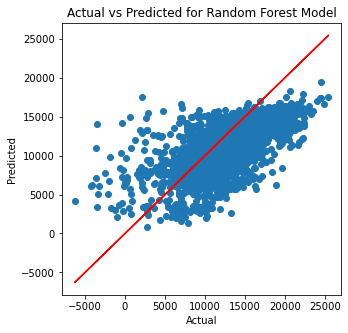

In [3784]:
# Create figure of random forest model
f, ax = plt.subplots(figsize=(5,5))

ax.set_title('Actual vs Predicted for Random Forest Model')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.scatter(y_test,test_rf_predict)
ax.plot(y_test,y_test,'r')
plt.show()

- Random Forest Model on Scaled Data

In [3785]:
RF_scaled = RandomForestRegressor(n_estimators = 40, max_features = 0.5, min_samples_leaf=3, n_jobs = -1, oob_score=True)

RF_scaled.fit(X_train2,y_train2)

RandomForestRegressor(max_features=0.5, min_samples_leaf=3, n_estimators=40,
                      n_jobs=-1, oob_score=True)

In [3786]:
test_rf_scaled = RF_scaled.predict(X_test2)
train_rf_scaled = RF_scaled.predict(X_train2)

In [3787]:
#RMSE for Random Forest with scaled data
math.sqrt(metrics.mean_squared_error(y_test, test_rf_scaled))

6588.965138431422

In [3788]:
metrics.mean_squared_error(y_train, train_rf_scaled)

44848801.98736994

In [3789]:
metrics.mean_squared_error(y_test, test_rf_scaled)

43414461.59546461

In [3790]:
metrics.mean_squared_error(y_test, test_rf_scaled) - metrics.mean_squared_error(y_train, train_rf_scaled)

-1434340.3919053301

- Hyper parameter tuning for Random Forest

In [3791]:
# Create the parameter grid 
parameters_rf ={"n_estimators" :    [50,100,150,200],
            "max_depth" :       [2,4,6,8,10,12,14],
           "min_samples_leaf":  [1,3,5,7,9,10],
           "min_samples_split":  [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features"    :   ["auto","sqrt"],
           "bootstrap":          [True, False] }

In [3792]:
# Fit the grid search to the data
rf_random = RandomizedSearchCV(estimator = RF_scaled,param_distributions = parameters_rf,
               n_iter = 100, cv=TimeSeriesSplit(n_splits=4), verbose=2, random_state=35, n_jobs = -1)

In [3793]:
#rf_random.fit(X_train2, y_train2)

In [3794]:
#print('Best Parameters: ', rf_random.best_params_, ' \n')

#### 5.2 Load Model
    * Build model
    * Split data into 3 parts 
        - train set
        - validation set
        - test set
    * View data shape

In [3795]:
# split data
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42, shuffle=False)

In [3796]:
# view shape of data
#print('X_train shape: {} - training set'.format(X_train.shape))
#print('y_train shape: {} - validation set'.format(y_train.shape))
#print('X_test shape: {}  - training set '.format(X_test.shape))
#print('y_test shape: {}  - validation set'.format(y_test.shape))

#### 5.3 Fit model 
    * Fit model
    * Create prediction variable

#### Linear Regression Model

In [3797]:
# build model - Linear Regression
#lr = LinearRegression()

In [3798]:
# fit model 
#lr.fit(X_train, y_train)

In [3799]:
# predict
#pred = lr.predict(X_test)

#### 5.4 Evaluate Model
    * Calculate and view prediction peformance
        - Mean Squared Error
        - r2 score

In [3800]:
# mean squared error 
#mse_eval = np.sqrt(MSE(y_test, pred))

In [3801]:
# r2 score
#r2_eval = r2(y_test, pred)

In [3802]:
# view performance 
#print('MSE: {}'.format(mse_eval))
#print('r2: {}'.format(r2_eval))

#### Random Forest Model

In [3803]:
#RF = RandomForestRegressor(n_estimators=100, max_depth=10)
#RF.fit(X_train,y_train)
#print(np.mean(cross_val_score(RF, X_train, y_train, cv=10)))

In [3804]:
#RF_predict = RF.predict(X_test)

In [3805]:
#print("MSE:",np.sqrt(MSE(y_test, RF_predict)))
#print("RMSE:",r2(y_test,RF_predict))

In [3806]:
#RF = RandomForestClassifier(max_depth=10)

In [3807]:
#RF.fit(X_train, y_train)

In [3808]:
#param_grid = {
                 #'n_estimators': [5, 10, 15, 20],
                 #'max_depth': [2, 5, 7, 9]
             #}

#grid_search = GridSearchCV(estimator=RF, param_grid= param_grid, cv=TimeSeriesSplit(n_splits=4)) 
#grid_search.fit(X_train, y_train)

In [3809]:
#grid_search.best_params_

In [3810]:
#RF = RandomForestClassifier(max_depth=5, n_estimators=10)
#RF.fit(X_train, y_train)

In [3811]:
#RF_pred = grid_search.predict(X_test)

In [3812]:
#print("MSE:",np.sqrt(MSE(y_test, RF_pred)))
#print("RMSE:",r2(y_test,RF_pred))

#### Support Vector Regressor

In [3813]:
#svr_params = {
    #'estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    #'estimator__gamma': ['scale','auto'],
    #'estimator__C':[0.1, 1, 2]}

In [3814]:
#svr = SVR()

In [3815]:
#svr.fit(X_train, y_train)

In [3816]:
#svr_gs = GridSearchCV(svr, 
                    #param_grid = svr_params, 
                    #cv=TimeSeriesSplit(n_splits=4)) 

In [3817]:
#svr_pred = svr_gs.predict(X_test)

In [3818]:
#print("MSE:",np.sqrt(MSE(y_test, svr_pred)))
#print("RMSE:",r2(y_test,svr_pred))

<a id="six"></a>
## 6. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Model performance ⚡ |
| :--------------------------- |
| In this section you are required to compare the relative performance of the various trained ML models on a holdout dataset and comment on what model is the best and why. |

---

In [3819]:
# Compare model performance

In [3820]:
# Choose best model and motivate why it is the best choice

<a id="seven"></a>
## 7. Model Explanations
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Model explanation ⚡ |
| :--------------------------- |
| In this section, you are required to discuss how the best performing model works in a simple way so that both technical and non-technical stakeholders can grasp the intuition behind the model's inner workings. |

---

In [3821]:
# discuss chosen methods logic

## 8. Kaggle Submission

##### 8.1 Model Preparation

In [3822]:
# Run this if testing for the first time in a session
time = test_data['time']

In [3823]:
#Run this if testing for the first time in a seesion 
test_data['time'] = pd.to_datetime(test_data['time'])
test_data['year'] = test_data['time'].dt.year
test_data['month'] = test_data['time'].dt.month
test_data['day'] = test_data['time'].dt.day
test_data['hour'] = test_data['time'].dt.hour
test_data['week_day'] = test_data['time'].dt.dayofweek
test_data[['year','month', 'day', 'week_day', 'hour']]

,year,month,day,week_day,hour
0,2018,1,1,0,0
1,2018,1,1,0,3
2,2018,1,1,0,6
3,2018,1,1,0,9
4,2018,1,1,0,12
...,...,...,...,...,...
2915,2018,12,31,0,9
2916,2018,12,31,0,12
2917,2018,12,31,0,15
2918,2018,12,31,0,18


In [3824]:
#Run this if testing for the first time in a session
test_data['Valencia_wind_deg'] = test_data['Valencia_wind_deg'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)
test_data['Seville_pressure'] = test_data['Seville_pressure'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)
test_data['Barcelona_pressure'].where(test_data['Barcelona_pressure'] <= 1084, 0, inplace=True)
test_data = test_data.drop(['Unnamed: 0', 'time', 'Bilbao_temp_max', 'Bilbao_temp_min', 'Seville_temp_max', 'Seville_temp_min', 
         'Madrid_temp_max', 'Madrid_temp_min', 'Valencia_temp_max', 'Valencia_temp_min', 'Barcelona_temp_max', 'Barcelona_temp_min', 'Valencia_snow_3h', 'Bilbao_snow_3h'], axis =1)
test_data['Wind_deg'] = test_data[['Valencia_wind_deg', 'Bilbao_wind_deg', 'Barcelona_wind_deg']].mean(axis=1)
test_data['Pressure'] = test_data[['Madrid_pressure', 'Valencia_pressure', 'Bilbao_pressure', 'Barcelona_pressure']].mean(axis=1)
test_data = test_data.drop(['Valencia_wind_deg', 'Bilbao_wind_deg', 'Barcelona_wind_deg', 'Madrid_pressure', 
              'Valencia_pressure', 'Bilbao_pressure', 'Seville_pressure', 'Barcelona_pressure'], axis =1)
test_data = test_data.drop(['Madrid_temp', 'Valencia_temp', 'Seville_temp', 'Bilbao_temp'], axis =1)

In [3825]:
#Run this if you are testing again in the same session - not for first test in session
test_data = test_data.drop(['time', 'load_shortfall_3h'], axis =1)

KeyError: "['time' 'load_shortfall_3h'] not found in axis"

In [3826]:
#Run this to test your model - change the name of the model you are testing 
test_data['load_shortfall_3h'] =RF.predict(test_data)

In [3827]:
#Add time back for the cv file
test_data['time'] = time

In [3828]:
test_data.head()

,Madrid_wind_speed,Bilbao_rain_1h,Valencia_wind_speed,Seville_humidity,Madrid_humidity,Bilbao_clouds_all,Bilbao_wind_speed,Seville_clouds_all,Barcelona_wind_speed,Madrid_clouds_all,Seville_wind_speed,Barcelona_rain_1h,Seville_rain_1h,Seville_rain_3h,Madrid_rain_1h,Barcelona_rain_3h,Madrid_weather_id,Barcelona_weather_id,Seville_weather_id,Bilbao_weather_id,Valencia_humidity,Barcelona_temp,year,month,day,hour,week_day,Wind_deg,Pressure,load_shortfall_3h,time
0,5.000000,0.0,5.000000,87.000000,71.333333,20.000000,3.000000,0.000000,4.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,800.0,800.000000,800.000000,801.000000,46.333333,287.356667,2018,1,1,0,0,126.000000,1024.333333,9080.040139,2018-01-01 00:00:00
1,4.666667,0.0,5.333333,89.000000,78.000000,0.000000,3.666667,0.000000,4.666667,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,800.0,800.333333,800.000000,721.000000,53.666667,284.190000,2018,1,1,3,0,139.333333,1025.777778,7649.204127,2018-01-01 03:00:00
2,2.333333,0.0,5.000000,89.000000,89.666667,0.000000,2.333333,6.666667,4.000000,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,800.0,800.000000,800.333333,800.000000,42.000000,283.150000,2018,1,1,6,0,133.444444,1026.333333,7866.389742,2018-01-01 06:00:00
3,2.666667,0.0,5.333333,93.333333,82.666667,26.666667,5.666667,6.666667,2.333333,0.0,1.333333,0.0,0.0,0.0,0.0,0.0,800.0,800.000000,800.333333,801.333333,45.000000,283.190000,2018,1,1,9,0,96.777778,1027.666667,9969.641280,2018-01-01 09:00:00
4,4.000000,0.0,8.666667,65.333333,64.000000,26.666667,10.666667,0.000000,4.666667,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,800.0,800.333333,800.000000,801.333333,41.000000,286.816667,2018,1,1,12,0,174.555556,1026.888889,10654.006528,2018-01-01 12:00:00


In [3829]:
# prepare vc file for submittal 
result = test_data[['time', 'load_shortfall_3h']]
result.to_csv('test_file.csv', index = False)
result

,time,load_shortfall_3h
0,2018-01-01 00:00:00,9080.040139
1,2018-01-01 03:00:00,7649.204127
2,2018-01-01 06:00:00,7866.389742
3,2018-01-01 09:00:00,9969.641280
4,2018-01-01 12:00:00,10654.006528
...,...,...
2915,2018-12-31 09:00:00,14412.263383
2916,2018-12-31 12:00:00,15057.862450
2917,2018-12-31 15:00:00,14574.594603
2918,2018-12-31 18:00:00,14713.937639


In [3830]:
test_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Madrid_wind_speed,2920.0,2.457820,1.774838,0.000000,1.333333,2.000000,3.333333,13.333333
Bilbao_rain_1h,2920.0,0.067517,0.153381,0.000000,0.000000,0.000000,0.000000,1.600000
Valencia_wind_speed,2920.0,3.012785,1.996340,0.000000,1.666667,2.333333,4.000000,14.333333
Seville_humidity,2920.0,67.123516,20.611292,11.666667,52.000000,70.333333,85.000000,100.000000
Madrid_humidity,2920.0,62.644463,24.138393,8.000000,43.000000,63.000000,84.000000,100.000000
Bilbao_clouds_all,2920.0,43.355422,30.486298,0.000000,13.333333,45.000000,75.000000,97.333333
Bilbao_wind_speed,2920.0,2.283562,1.654787,0.000000,1.000000,1.666667,3.333333,10.666667
Seville_clouds_all,2920.0,15.477283,25.289197,0.000000,0.000000,0.000000,20.000000,93.333333
Barcelona_wind_speed,2920.0,2.518094,1.625507,0.000000,1.333333,2.000000,3.666667,12.666667
Madrid_clouds_all,2920.0,24.255822,29.430257,0.000000,0.000000,11.333333,40.000000,92.000000


##### 8.2 Output Dataframe - csv
    * Create dataframe
    * Create and view submission csv file

In [ ]:
test_data['Valencia_wind_deg'] = test_data['Valencia_wind_deg'].str.extract('(\d+)').astype('int64')
test_data['Seville_pressure'] = test_data['Seville_pressure'].str.extract('(\d+)').astype('int64')

KeyError: 'Valencia_wind_deg'

In [ ]:
test_data['load_shortfall_3h'] = svr.predict(test_data)

In [ ]:
test_data['time'] = time
load = test_data[['time','load_shortfall_3h']]
load.to_csv('submission13.csv', index = False)
load

,time,load_shortfall_3h
0,2018-01-01 00:00:00,11045.339899
1,2018-01-01 03:00:00,11045.339899
2,2018-01-01 06:00:00,11045.339899
3,2018-01-01 09:00:00,11045.339899
4,2018-01-01 12:00:00,11045.339899
...,...,...
2915,2018-12-31 09:00:00,11045.339899
2916,2018-12-31 12:00:00,11045.339899
2917,2018-12-31 15:00:00,11045.339899
2918,2018-12-31 18:00:00,11045.339899
